# Graph learning

## JanusGraph-Visualizer queries

- Visualize only the collaboration pattern nodes, situation nodes, and action nodes
  - `g.V().not(hasLabel(containing("participant_").or(eq("robot"))))`
- Visualize the situation vertices of interest
  - `g.V().hasLabel("situation_1", "situation_2")`

## Start HumemAI

In [1]:
from humemai.utils import disable_logger
disable_logger()

from gremlin_python.structure.graph import Graph, Vertex, Edge
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.driver.serializer import GraphSONSerializersV3d0
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.traversal import P, T, Direction

import json
from humemai.janusgraph import Humemai
from tqdm.auto import tqdm

humemai = Humemai()
# humemai.start_containers()
humemai.connect()
# humemai.remove_all_data()


with open("./raw-data.json") as f:
    data = json.load(f)

# humemai.disconnect()
# humemai.stop_containers()
# humemai.remove_containers()

from humemai.utils import disable_logger
disable_logger()

/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DEBUG:docker.utils.config:Trying paths: ['/home/tk/.docker/config.json', '/home/tk/.dockercfg']
DEBUG:docker.utils.config:No config file found
DEBUG:docker.utils.config:Trying paths: ['/home/tk/.docker/config.json', '/home/tk/.dockercfg']
DEBUG:docker.utils.config:No config file found
DEBUG:urllib3.connectionpool:http://localhost:None "GET /version HTTP/11" 200 834
INFO:gremlinpython:Creating DriverRemoteConnection with url 'ws://localhost:8182/gremlin'
INFO:gremlinpython:Creating Client with url 'ws://localhost:8182/gremlin'
INFO:gremlinpython:Creating GraphTraversalSource.
INFO:gremlinpython:Creating GraphTraversalSource.
DEBUG:humemai.janusgraph.humemai:Successfully connected to the Gremlin server.


## Write the co-learning data to HumemAI

In [14]:
humemai.g.V().toList()

[v[536704],
 v[933912],
 v[942144],
 v[1085632],
 v[995544],
 v[766016],
 v[815296],
 v[2015384],
 v[598040],
 v[606256],
 v[1069248],
 v[671808],
 v[1515672],
 v[970800],
 v[1310872],
 v[2179224],
 v[659648],
 v[1986712],
 v[2072728],
 v[1675416],
 v[794648],
 v[770096],
 v[803056],
 v[1102064],
 v[1130712],
 v[913632],
 v[962608],
 v[745664],
 v[934016],
 v[786480],
 v[1720472],
 v[823424],
 v[995568],
 v[745600],
 v[577560],
 v[614624],
 v[897248],
 v[974912],
 v[680000],
 v[2285720],
 v[1429656],
 v[2203800],
 v[606336],
 v[860376],
 v[618624],
 v[1069080],
 v[778288],
 v[1204376],
 v[716992],
 v[860208],
 v[1245336],
 v[2031768],
 v[2056344],
 v[639200],
 v[839728],
 v[2044056],
 v[831704],
 v[1482904],
 v[606432],
 v[651488],
 v[622832],
 v[1073200],
 v[2093208],
 v[631024],
 v[614592],
 v[1159384],
 v[1097944],
 v[581696],
 v[1773720],
 v[610432],
 v[782528],
 v[925920],
 v[757784],
 v[794840],
 v[2138264],
 v[995352],
 v[975072],
 v[1011736],
 v[831728],
 v[901184],
 v[684224],

In [11]:
humemai.remove_all_data()


for data_point in tqdm(data):
    event_time = data_point["timestamp"]

    robot_vertex = humemai.write_long_term_vertex("robot", {"event_time": event_time})
    cp_label = "cp_" + str(data_point["cp_num"])
    cp_properties = {
        "cp_num": data_point["cp_num"],
        "participant_num": data_point["participant"],
        "cp_name": data_point["cp_name"],
        "ticks_lasted": data_point["ticks_lasted"],
        "round_num": data_point["round_num"],
        "event_time": data_point["timestamp"],
        "remaining_time": data_point["remaining_time"],
        "remaining_rocks": data_point["remaining_rocks"],
        "victim_harm": data_point["victim_harm"],
    }

    cp_vertex = humemai.write_long_term_vertex(cp_label, cp_properties)
    humemai.write_long_term_edge(
        robot_vertex, "has_cp", cp_vertex, {"event_time": event_time}
    )

    participant_label = "participant_" + str(data_point["participant"])
    participant_vertex = humemai.write_long_term_vertex(
        participant_label, {"event_time": event_time}
    )
    humemai.write_long_term_edge(
        participant_vertex, "has_cp", cp_vertex, {"event_time": event_time}
    )

    situation = [bar for foo in data_point["situation"] for bar in foo]

    if situation:
        situation_label = "situation_" + str(data_point["cp_num"])
        situation_properties = {s["type"]: s["content"] for s in situation}
        situation_properties["event_time"] = event_time
        situation_vertex = humemai.write_long_term_vertex(
            situation_label, situation_properties
        )
        humemai.write_long_term_edge(
            cp_vertex, "has_situation", situation_vertex, {"event_time": event_time}
        )

        human_action_properties = {}
        for idx, list_ in enumerate(data_point["HumanAction"]):

            if list_:
                human_action_label = "human_action_" + str(idx)
                properties = {"event_time": event_time}
                for action in list_:
                    properties[action["type"]] = action["content"]

                human_action_properties[idx] = properties

                human_action_vertex = humemai.write_long_term_vertex(
                    human_action_label, properties
                )
                humemai.write_long_term_edge(
                    situation_vertex,
                    "has_human_action_" + str(idx),
                    human_action_vertex,
                    {"event_time": event_time},
                )

        robot_action_properties = {}
        for idx, list_ in enumerate(data_point["RobotAction"]):

            if list_:
                robot_action_label = "robot_action_" + str(idx)
                properties = {"event_time": event_time}
                for action in list_:
                    properties[action["type"]] = action["content"]

                robot_action_properties[idx] = properties

                robot_action_vertex = humemai.write_long_term_vertex(
                    robot_action_label, properties
                )
                humemai.write_long_term_edge(
                    situation_vertex,
                    "has_robot_action_" + str(idx),
                    robot_action_vertex,
                    {"event_time": event_time},
                )

# # Merge the duplicate nodes
# humemai.connect_duplicate_vertices("exact_label")

100%|██████████| 211/211 [00:02<00:00, 73.68it/s]


### `g.V()`
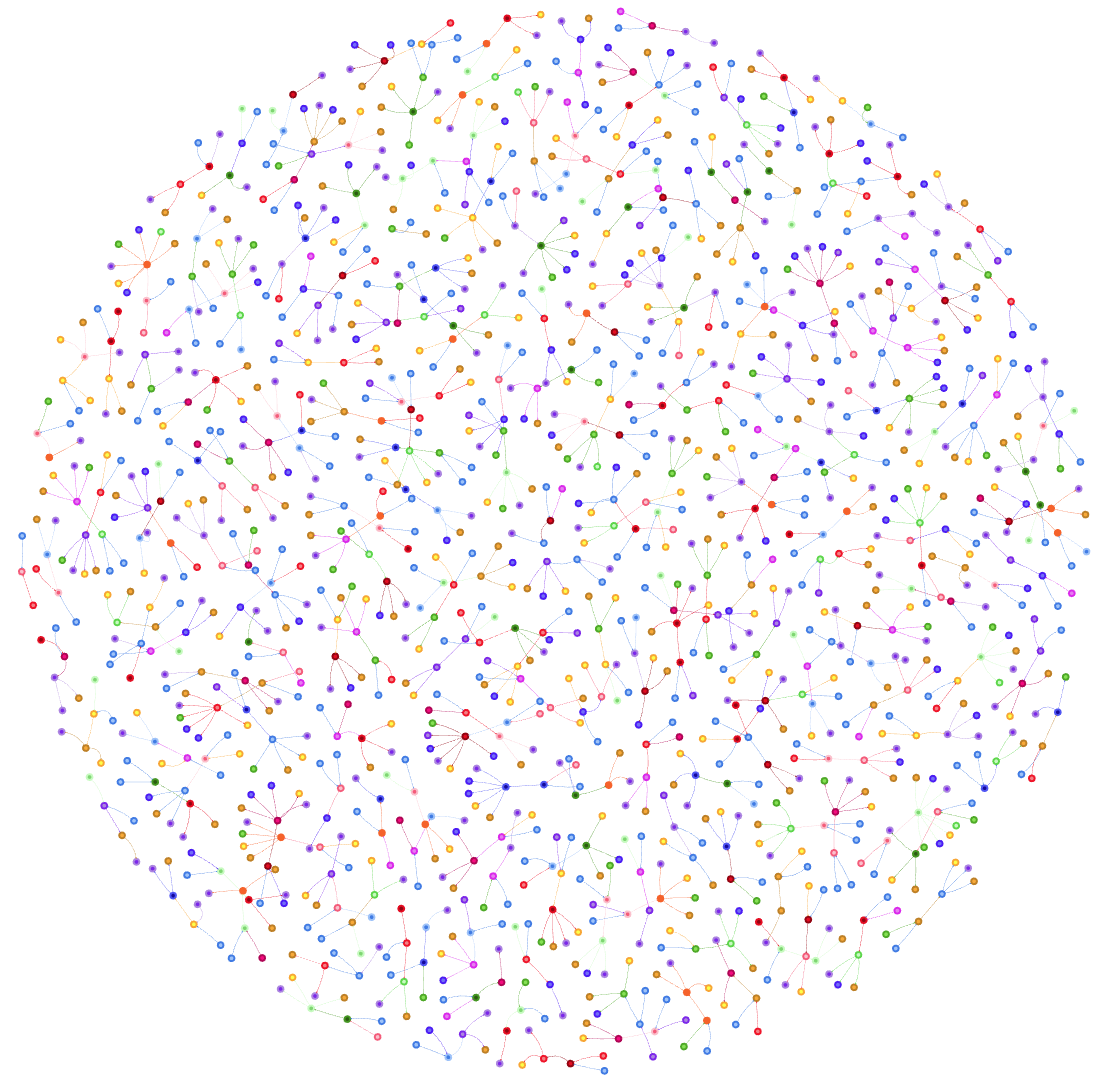


### `g.V().not(hasLabel(containing("participant_").or(eq("robot"))))`
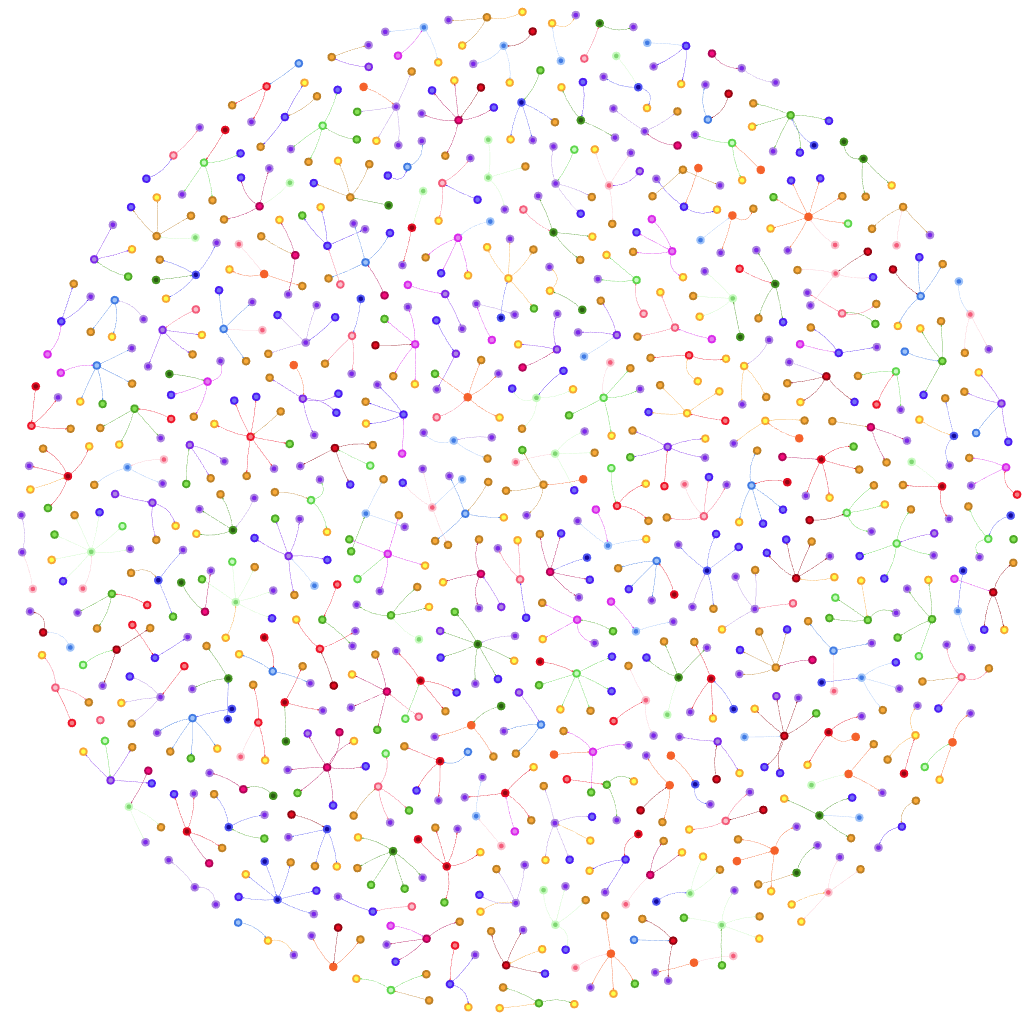

## Get some stats

In [ ]:
from gremlin_python.process.traversal import TextP

ticks_lasted_min = humemai.g.V() \
    .hasLabel(TextP.containing("cp_")) \
    .values("ticks_lasted").order().limit(1).next()

ticks_lasted_max = humemai.g.V() \
    .hasLabel(TextP.containing("cp_")) \
    .values("ticks_lasted").order().tail(1).next()

remaining_time_min = humemai.g.V() \
    .hasLabel(TextP.containing("cp_")) \
    .values("remaining_time").order().limit(1).next()

remaining_time_max = humemai.g.V() \
    .hasLabel(TextP.containing("cp_")) \
    .values("remaining_time").order().tail(1).next()

remaining_rocks_min = humemai.g.V() \
    .hasLabel(TextP.containing("cp_")) \
    .values("remaining_rocks").order().limit(1).next()

remaining_rocks_max = humemai.g.V() \
    .hasLabel(TextP.containing("cp_")) \
    .values("remaining_rocks").order().tail(1).next()

victim_harm_min = humemai.g.V() \
    .hasLabel(TextP.containing("cp_")) \
    .values("victim_harm").order().limit(1).next()

victim_harm_max = humemai.g.V() \
    .hasLabel(TextP.containing("cp_")) \
    .values("victim_harm").order().tail(1).next()

round_num_min = humemai.g.V() \
    .hasLabel(TextP.containing("cp_")) \
    .values("round_num").order().limit(1).next()

round_num_max = humemai.g.V() \
    .hasLabel(TextP.containing("cp_")) \
    .values("round_num").order().tail(1).next()

print("Ticks lasted: ", ticks_lasted_min, ticks_lasted_max)
print("Remaining time: ", remaining_time_min, remaining_time_max)
print("Remaining rocks: ", remaining_rocks_min, remaining_rocks_max)
print("Victim harm: ", victim_harm_min, victim_harm_max)
print("Round num: ", round_num_min, round_num_max)


## Write the vector representations of the nodes to the database

In [4]:
import numpy as np
import json
from gremlin_python.process.traversal import P, T, Direction, TextP
from sentence_transformers import SentenceTransformer

# Load a pre-trained Sentence-BERT model
model = SentenceTransformer("all-mpnet-base-v2")


def turn_properties_into_string(properties):
    to_return = ""
    if "action" in properties:
        to_return += "Action: " + properties["action"] + ". "
    if "actor" in properties:
        to_return += "Actor: " + properties["actor"] + ". "
    if "location" in properties:
        to_return += "Location: " + properties["location"] + ". "
    if "object" in properties:
        to_return += "Object: " + properties["object"] + ". "

    return to_return


situation_vertices = humemai.g.V().hasLabel(TextP.containing("situation_")).toList()
for situation_vertex in tqdm(situation_vertices):
    # Get situation node details
    situation_label = situation_vertex.label
    situation_properties = humemai.get_properties(situation_vertex)
    situation_properties_str = turn_properties_into_string(situation_properties)
    situation_properties_vector = model.encode(situation_properties_str)
    humemai.update_vertex_properties(
        situation_vertex,
        {
            "sentence_representation": situation_properties_str,
            "vector_representation": json.dumps(situation_properties_vector.tolist()),
        },
    )

    # Get the connected cp vertex
    cp_vertex = (
        humemai.g.V(situation_vertex).inE().hasLabel("has_situation").outV().next()
    )
    cp_label = cp_vertex.label
    cp_properties = humemai.get_properties(cp_vertex)
    cp_properties_vector = np.array(
        [
            cp_properties["ticks_lasted"] / ticks_lasted_max,
            cp_properties["remaining_time"] / remaining_time_max,
            cp_properties["remaining_rocks"] / remaining_rocks_max,
            cp_properties["victim_harm"] / victim_harm_max,
            cp_properties["round_num"] / round_num_max,
        ]
    )
    humemai.update_vertex_properties(
        cp_vertex,
        {
            "vector_representation": json.dumps(cp_properties_vector.tolist()),
        },
    )

    # Get human action vertices
    human_actions = (
        humemai.g.V(situation_vertex)
        .outE()
        .hasLabel(TextP.containing("has_human_action"))
        .inV()
        .toList()
    )
    for human_action in human_actions:
        human_action_properties = humemai.get_properties(human_action)
        human_action_properties_str = turn_properties_into_string(
            human_action_properties
        )
        human_action_properties_vector = model.encode(human_action_properties_str)
        humemai.update_vertex_properties(
            human_action,
            {
                "sentence_representation": human_action_properties_str,
                "vector_representation": json.dumps(
                    human_action_properties_vector.tolist()
                ),
            },
        )

    # Get robot action vertices
    robot_actions = (
        humemai.g.V(situation_vertex)
        .outE()
        .hasLabel(TextP.containing("has_robot_action"))
        .inV()
        .toList()
    )
    for robot_action in robot_actions:
        robot_action_properties = humemai.get_properties(robot_action)
        robot_action_properties_str = turn_properties_into_string(
            robot_action_properties
        )
        robot_action_properties_vector = model.encode(robot_action_properties_str)
        humemai.update_vertex_properties(
            robot_action,
            {
                "sentence_representation": robot_action_properties_str,
                "vector_representation": json.dumps(
                    robot_action_properties_vector.tolist()
                ),
            },
        )

100%|██████████| 209/209 [00:17<00:00, 12.18it/s]


### `g.V().not(hasLabel(containing("participant_").or(eq("robot"))))`

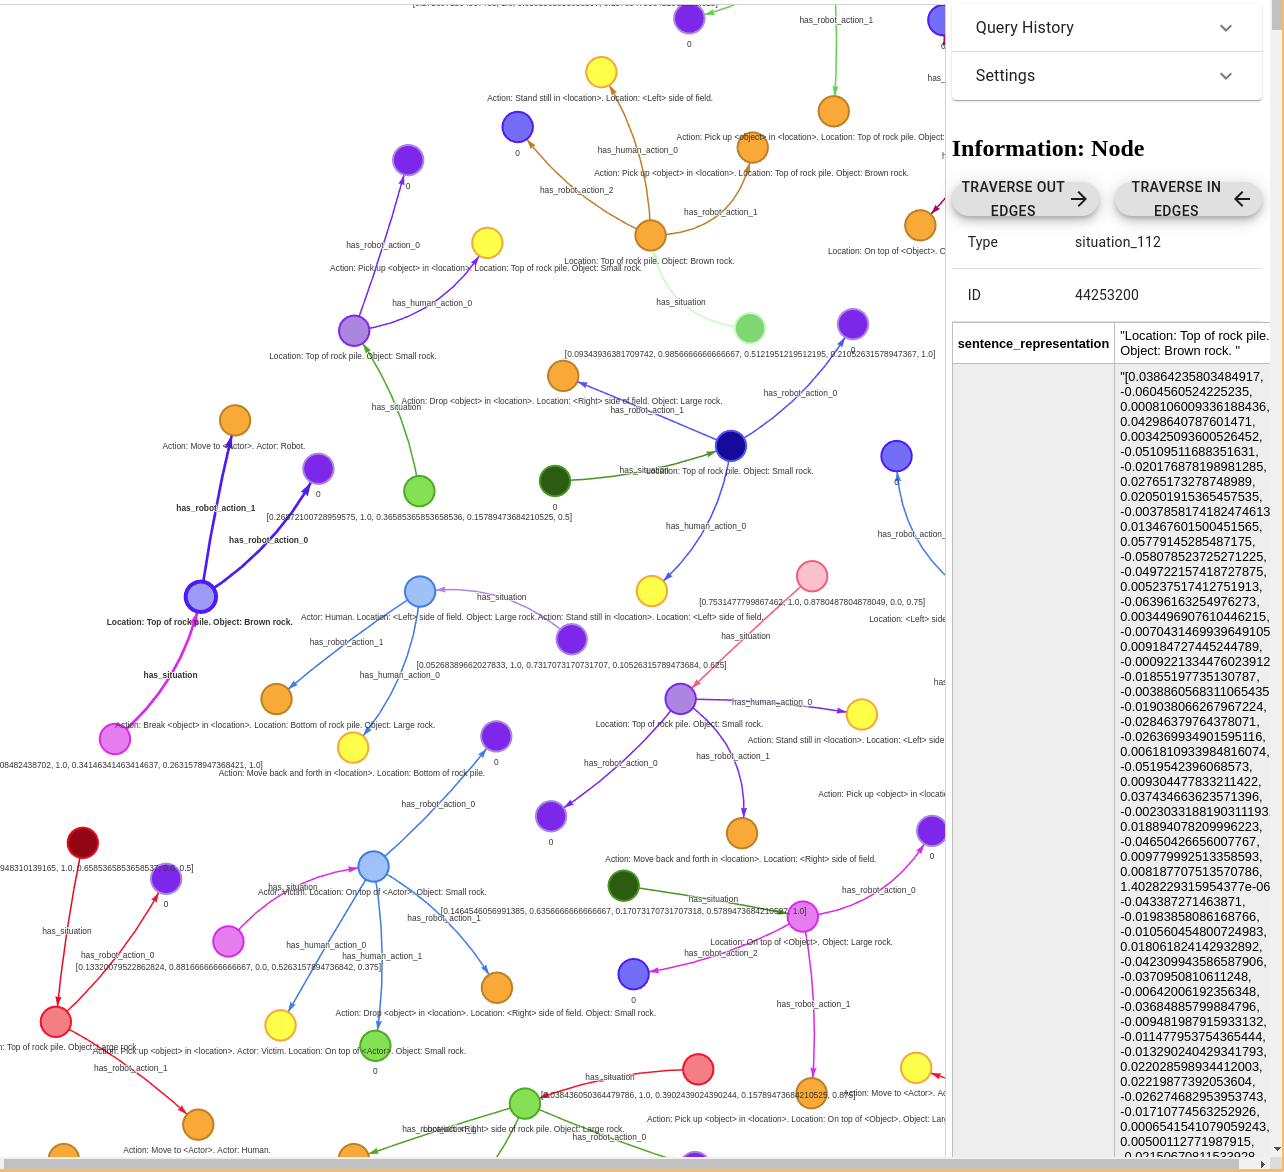

## Get the stuff, e.g., adjacency matrix, from the graphs for GNN

### Vertex-Type Classes

| Node Type      | Class ID |
| -------------- | -------- |
| situation      | 0        |
| cp             | 1        |
| human_action_0 | 2        |
| human_action_1 | 3        |
| human_action_2 | 4        |
| robot_action_0 | 5        |
| robot_action_1 | 6        |
| robot_action_2 | 7        |
| robot_action_3 | 8        |
| robot_action_4 | 9        |

### Edge-Type classes

| Vertex Class       | Class IDs |
| ------------------ | --------- |
| has_situation      | 0         |
| has_human_action_0 | 1         |
| has_human_action_1 | 2         |
| has_human_action_2 | 3         |
| has_robot_action_0 | 4         |
| has_robot_action_1 | 5         |
| has_robot_action_2 | 6         |
| has_robot_action_3 | 7         |
| has_robot_action_4 | 8         |


In [5]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import add_self_loops
import random

num_node_types = 10
small_dim = 5
big_dim = 768
num_original_edge_types = 9
relation_mode = ["default", "include_self_loop", "include_self_loop_and_inv"][2]
if relation_mode == "default":
    num_edge_types = num_original_edge_types
elif relation_mode == "include_self_loop":
    num_edge_types = num_original_edge_types + 1
elif relation_mode == "include_self_loop_and_inv":
    num_edge_types = 2 * num_original_edge_types + 1

situation_vertices = humemai.g.V().hasLabel(TextP.containing("situation_")).toList()

dataset = []
for situation_vertex in tqdm(situation_vertices):

    vertices, edges = humemai.get_within_hops([situation_vertex], 1)

    node_features = torch.zeros(len(vertices), big_dim)
    edge_index = []
    node_classes = []
    edge_type = []
    is_small_dim = []

    # Extract labels
    vertex_labels = [vertex.label for vertex in vertices]
    inV_labels = [edge.inV.label for edge in edges]
    outV_labels = [edge.outV.label for edge in edges]
    edge_labels = [edge.label for edge in edges]

    # Compute max widths
    max_v_len = max(len(lbl) for lbl in vertex_labels) if vertex_labels else 0
    max_inV_len = max(len(lbl) for lbl in inV_labels) if inV_labels else 0
    max_edge_len = max(len(lbl) for lbl in edge_labels) if edge_labels else 0
    max_outV_len = max(len(lbl) for lbl in outV_labels) if outV_labels else 0

    # Print vertex labels
    # print("Vertices:")
    for idx, v in enumerate(vertex_labels):
        # print(v.ljust(max_v_len))
        if "situation_" in v:
            node_classes.append(0)
            is_small_dim.append(0)
        elif "cp_" in v:
            node_classes.append(1)
            is_small_dim.append(1)
        elif "human_action_0" in v:
            node_classes.append(2)
            is_small_dim.append(0)
        elif "human_action_1" in v:
            node_classes.append(3)
            is_small_dim.append(0)
        elif "human_action_2" in v:
            node_classes.append(4)
            is_small_dim.append(0)
        elif "robot_action_0" in v:
            node_classes.append(5)
            is_small_dim.append(0)
        elif "robot_action_1" in v:
            node_classes.append(6)
            is_small_dim.append(0)
        elif "robot_action_2" in v:
            node_classes.append(7)
            is_small_dim.append(0)
        elif "robot_action_3" in v:
            node_classes.append(8)
            is_small_dim.append(0)
        elif "robot_action_4" in v:
            node_classes.append(9)
            is_small_dim.append(0)
        else:
            raise ValueError(f"Unknown vertex label: {v}")

        feats = torch.tensor(
            json.loads(humemai.get_properties(vertices[idx])["vector_representation"])
        )
        if feats.shape[0] == big_dim:
            node_features[idx] = feats
        elif feats.shape[0] == small_dim:
            node_features[idx, :small_dim] = feats
        else:
            raise ValueError(f"Unknown feature shape: {feats.shape}")

    is_small_dim = torch.tensor(is_small_dim)
    node_classes = torch.tensor(node_classes)

    # print()

    # print("Edges:")
    for edge in edges:
        # print(
        #     f"{edge.outV.label.ljust(max_inV_len)}    "
        #     f"{edge.label.ljust(max_edge_len)}    "
        #     f"{edge.inV.label.ljust(max_outV_len)}"
        # )
        if "has_situation" in edge.label:
            edge_type.append(0)
        elif "has_human_action_0" in edge.label:
            edge_type.append(1)
        elif "has_human_action_1" in edge.label:
            edge_type.append(2)
        elif "has_human_action_2" in edge.label:
            edge_type.append(3)
        elif "has_robot_action_0" in edge.label:
            edge_type.append(4)
        elif "has_robot_action_1" in edge.label:
            edge_type.append(5)
        elif "has_robot_action_2" in edge.label:
            edge_type.append(6)
        elif "has_robot_action_3" in edge.label:
            edge_type.append(7)
        elif "has_robot_action_4" in edge.label:
            edge_type.append(8)
        else:
            raise ValueError(f"Unknown edge label: {edge.label}")

        edge_index.append(
            [
                vertex_labels.index(edge.outV.label),
                vertex_labels.index(edge.inV.label),
            ]
        )
    edge_index = torch.tensor(edge_index).T

    edge_type = torch.tensor(edge_type)

    # print()  # Blank line after each situation graph

    if relation_mode == "default":
        pass
    elif relation_mode == "include_self_loop":
        edge_index, edge_type = add_self_loops(
            edge_index, edge_type, fill_value=num_original_edge_types
        )
    elif relation_mode == "include_self_loop_and_inv":
        # Add inverse relations
        src, dst = edge_index
        inv_edge_index = torch.stack([dst, src], dim=0)
        inv_edge_type = edge_type + num_original_edge_types
        edge_index = torch.cat([edge_index, inv_edge_index], dim=1)
        edge_type = torch.cat([edge_type, inv_edge_type], dim=0)

        # Add self-loops with new relation type = 2N
        edge_index, edge_type = add_self_loops(
            edge_index, edge_type, fill_value=(2 * num_original_edge_types)
        )

    data = Data(
        node_features=node_features,
        edge_index=edge_index,
        node_classes=node_classes,
        edge_type=edge_type,
        is_small_dim=is_small_dim,
    )
    dataset.append(data)

/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
100%|██████████| 209/209 [00:00<00:00, 349.22it/s]


## Visualize the vectors (before training)

100%|██████████| 209/209 [00:00<00:00, 34282.74it/s]
/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


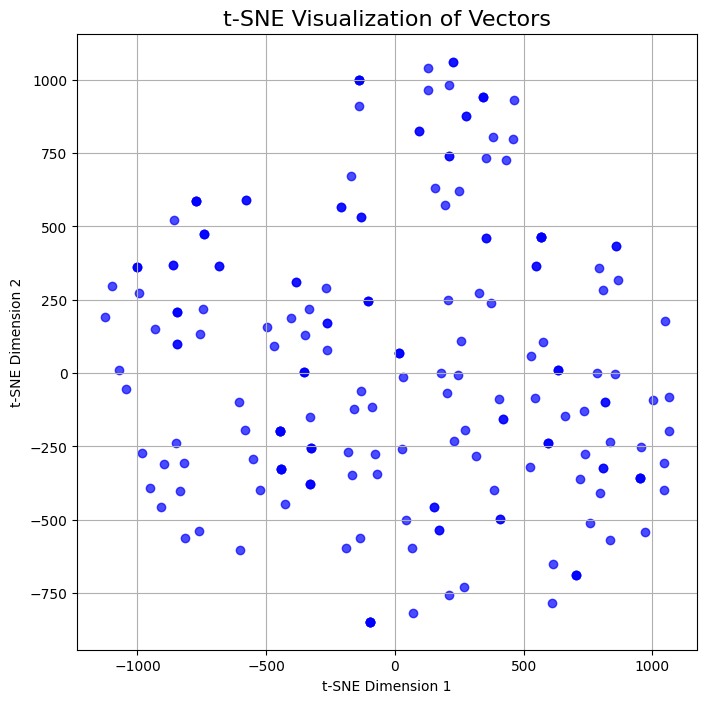

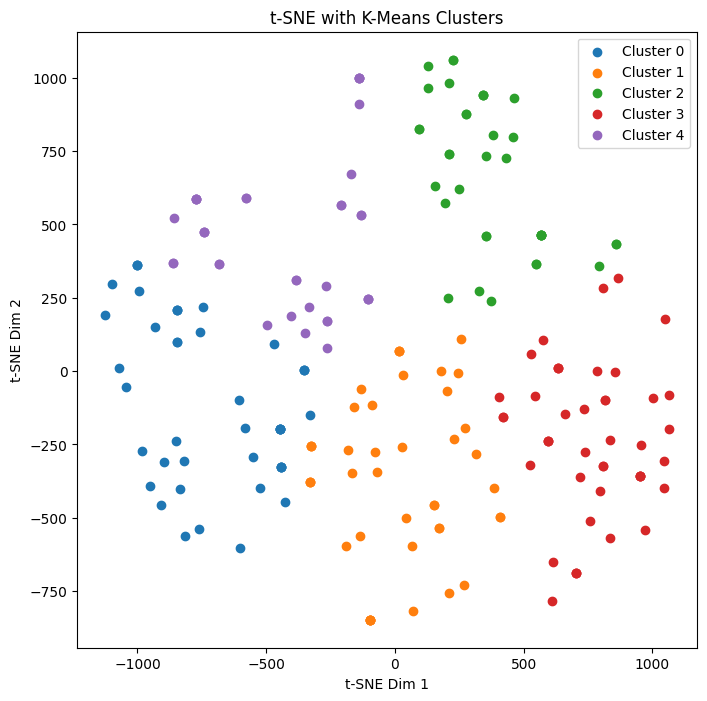

Cluster 2: (count: 37)
Ticks lasted: 718
Remaining time: 2465
Remaining rocks: 15
Victim harm: 270
Round num: 5

Cluster 3: (count: 46)
Ticks lasted: 905
Remaining time: 2763
Remaining rocks: 17
Victim harm: 226
Round num: 5

Cluster 0: (count: 45)
Ticks lasted: 1263
Remaining time: 2575
Remaining rocks: 15
Victim harm: 320
Round num: 4

Cluster 1: (count: 44)
Ticks lasted: 743
Remaining time: 2439
Remaining rocks: 12
Victim harm: 381
Round num: 5

Cluster 4: (count: 37)
Ticks lasted: 1065
Remaining time: 2729
Remaining rocks: 14
Victim harm: 337
Round num: 5

Closest point to centroid of Cluster 0: situation_63
Closest point to centroid of Cluster 1: situation_125
Closest point to centroid of Cluster 2: situation_108
Closest point to centroid of Cluster 3: situation_52
Closest point to centroid of Cluster 4: situation_153


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


node_features = []
for data_sample in tqdm(dataset):
    node_features_ = np.array([
        node_features_
        for node_features_, is_small_dim_ in zip(
            data_sample.node_features, data_sample.is_small_dim
        )
        if is_small_dim_ == 0
    ]).mean(axis=0)
    node_features.append(node_features_)
node_features = np.array(node_features)

# Apply t-SNE to reduce dimensions to 2D for visualization
tsne = TSNE(
    n_components=2,
    perplexity=30,        # Good balance for most datasets
    n_iter=2000,          # Enough for convergence
    learning_rate=200,    # Default, balanced value
    metric="euclidean",      # Use cosine for high-dimensional data
    init="pca",           # Stable initialization
    random_state=42       # Reproducible results
)

vectors_2d = tsne.fit_transform(node_features)

# Plot the 2D visualization
plt.figure(figsize=(8, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c="blue", alpha=0.7)
plt.title("t-SNE Visualization of Vectors", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume `tsne_results` is the 2D output of t-SNE (shape: [num_points, 2])
# Number of clusters to form
num_clusters = 5

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors_2d)

# Visualize the clusters
plt.figure(figsize=(8, 8))
for cluster in range(num_clusters):
    plt.scatter(vectors_2d[cluster_labels == cluster, 0], 
                vectors_2d[cluster_labels == cluster, 1], 
                label=f"Cluster {cluster}")
plt.legend()
plt.title("t-SNE with K-Means Clusters")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

from collections import Counter

cluster_dict = dict(Counter(cluster_labels))

ticks_lasted = []
remaining_time = []
remaining_rocks = []
victim_harm = []
round_num = []

for vertex in situation_vertices:
    cp_vertex = humemai.g.V(vertex).inE("has_situation").outV().next()
    properties = humemai.get_properties(cp_vertex)
    ticks_lasted.append(properties["ticks_lasted"])
    remaining_time.append(properties["remaining_time"])
    remaining_rocks.append(properties["remaining_rocks"])
    victim_harm.append(properties["victim_harm"])
    round_num.append(properties["round_num"])

ticks_lasted = np.array(ticks_lasted)
remaining_time = np.array(remaining_time)
remaining_rocks = np.array(remaining_rocks)
victim_harm = np.array(victim_harm)
round_num = np.array(round_num)

for label, val in cluster_dict.items():
    print(f"Cluster {label}: (count: {val})")
    print(f"Ticks lasted: {int(ticks_lasted[cluster_labels == label].mean())}")
    print(f"Remaining time: {int(remaining_time[cluster_labels == label].mean())}")
    print(f"Remaining rocks: {int(remaining_rocks[cluster_labels == label].mean())}")
    print(f"Victim harm: {int(victim_harm[cluster_labels == label].mean())}")
    print(f"Round num: {int(round_num[cluster_labels == label].mean())}")
    print()
    
import numpy as np

# Get the cluster centroids from K-Means
centroids = kmeans.cluster_centers_

# Find the closest data point to each centroid
closest_points = []

for cluster_id in range(num_clusters):
    # Get the indices of points in the current cluster
    cluster_points = vectors_2d[cluster_labels == cluster_id]
    original_indices = np.where(cluster_labels == cluster_id)[0]

    # Compute the distances to the centroid
    distances = np.linalg.norm(cluster_points - centroids[cluster_id], axis=1)

    # Find the index of the closest point
    closest_point_idx = original_indices[np.argmin(distances)]
    closest_points.append(closest_point_idx)

# Output the closest data points for each cluster
for cluster_id, point_idx in enumerate(closest_points):
    print(f"Closest point to centroid of Cluster {cluster_id}: {situation_vertices[point_idx].label}")


## Define classes and functions for training RGCN

In [7]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import add_self_loops
import random


class RGCN(torch.nn.Module):
    def __init__(
        self, small_dim, big_dim, num_hidden_channels, num_edge_types, num_node_types
    ):
        super().__init__()
        # This MLP will be used to upscale small_dim features to big_dim
        self.small_dim = small_dim
        self.big_dim = big_dim
        self.upscale = Linear(small_dim, big_dim)

        # After upscaling, all features are big_dim
        self.conv1 = RGCNConv(big_dim, num_hidden_channels, num_edge_types)
        self.conv2 = RGCNConv(num_hidden_channels, num_hidden_channels, num_edge_types)
        self.fc = Linear(num_hidden_channels, num_node_types)

    def forward(self, node_features, edge_index, edge_type, is_small_dim):
        # node_features is [num_nodes, small_dim or big_dim]
        # is_m_dim is a boolean mask: True where node features were originally M-dim

        # Upscale only those nodes that are small_dim
        # Extract small_dim node features (only first small_dim entries are relevant)

        # shape: [num_small_dim_nodes, small_dim]
        small_dim_nodes = node_features[is_small_dim, : self.small_dim]

        # shape: [num_small_dim_nodes, big_dim]
        small_dim_nodes_upscaled = self.upscale(small_dim_nodes)

        # Replace the small_dim node rows in node_features with the upscaled features
        node_features_new = node_features.clone()
        node_features_new[is_small_dim] = small_dim_nodes_upscaled
        node_features = node_features_new

        # Now all nodes are effectively big_dim
        self.node_features_1 = self.conv1(node_features, edge_index, edge_type)
        self.node_features_1_relu = F.relu(self.node_features_1)
        self.node_features_2 = self.conv2(self.node_features_1_relu, edge_index, edge_type)
        self.output = self.fc(self.node_features_2)

        return self.output


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_rgcn(
    model,
    dataset,
    num_edge_types,
    num_hidden_channels,
    batch_size,
    num_epochs,
    small_dim,
    big_dim,
    device,
    num_node_types,
):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(
                batch.node_features,
                batch.edge_index,
                batch.edge_type,
                batch.is_small_dim,
            )

            # Compute loss
            loss = loss_fn(out, batch.node_classes)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(out, dim=1)  # Get predicted class indices
            correct_predictions += (predicted == batch.node_classes).sum().item()
            total_samples += batch.node_classes.size(0)

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(loader)
        accuracy = correct_predictions / total_samples

        # if (epoch + 1) % 100 == 0:
        print(
            f"Mode {relation_mode}, Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}"
        )

## Train!

In [42]:
num_epochs = 1000
batch_size = len(dataset)
num_hidden_channels = 8
device = "cpu"
print(f"Training with {relation_mode} relations:")


model = RGCN(
    small_dim=small_dim,
    big_dim=big_dim,
    num_hidden_channels=num_hidden_channels,
    num_edge_types=num_edge_types,
    num_node_types=num_node_types,
).to(device)
print(f"number of parameters: {count_parameters(model)}")


train_rgcn(
    model=model,
    dataset=dataset,
    num_edge_types=num_edge_types,
    num_hidden_channels=num_hidden_channels,
    batch_size=batch_size,
    num_epochs=num_epochs,
    small_dim=small_dim,
    big_dim=big_dim,
    device=device,
    num_node_types=num_node_types,
)

Training with include_self_loop_and_inv relations:
number of parameters: 128874
Mode include_self_loop_and_inv, Epoch 1, Loss: 2.3227, Accuracy: 0.0394
Mode include_self_loop_and_inv, Epoch 2, Loss: 2.2636, Accuracy: 0.1400
Mode include_self_loop_and_inv, Epoch 3, Loss: 2.2123, Accuracy: 0.2531
Mode include_self_loop_and_inv, Epoch 4, Loss: 2.1612, Accuracy: 0.3496
Mode include_self_loop_and_inv, Epoch 5, Loss: 2.1078, Accuracy: 0.4243


/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Mode include_self_loop_and_inv, Epoch 6, Loss: 2.0526, Accuracy: 0.4668
Mode include_self_loop_and_inv, Epoch 7, Loss: 1.9920, Accuracy: 0.4865
Mode include_self_loop_and_inv, Epoch 8, Loss: 1.9288, Accuracy: 0.5052
Mode include_self_loop_and_inv, Epoch 9, Loss: 1.8674, Accuracy: 0.5124
Mode include_self_loop_and_inv, Epoch 10, Loss: 1.8050, Accuracy: 0.5145
Mode include_self_loop_and_inv, Epoch 11, Loss: 1.7454, Accuracy: 0.5145
Mode include_self_loop_and_inv, Epoch 12, Loss: 1.6875, Accuracy: 0.5145
Mode include_self_loop_and_inv, Epoch 13, Loss: 1.6330, Accuracy: 0.5145
Mode include_self_loop_and_inv, Epoch 14, Loss: 1.5822, Accuracy: 0.5145
Mode include_self_loop_and_inv, Epoch 15, Loss: 1.5341, Accuracy: 0.5145
Mode include_self_loop_and_inv, Epoch 16, Loss: 1.4871, Accuracy: 0.5145
Mode include_self_loop_and_inv, Epoch 17, Loss: 1.4399, Accuracy: 0.5145
Mode include_self_loop_and_inv, Epoch 18, Loss: 1.3979, Accuracy: 0.5145
Mode include_self_loop_and_inv, Epoch 19, Loss: 1.3548,

## Visualize again (after training)

### Represent every graph as one vector by the mean of the node_features

100%|██████████| 209/209 [00:00<00:00, 436.91it/s]
/home/tk/.virtualenvs/humemai/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


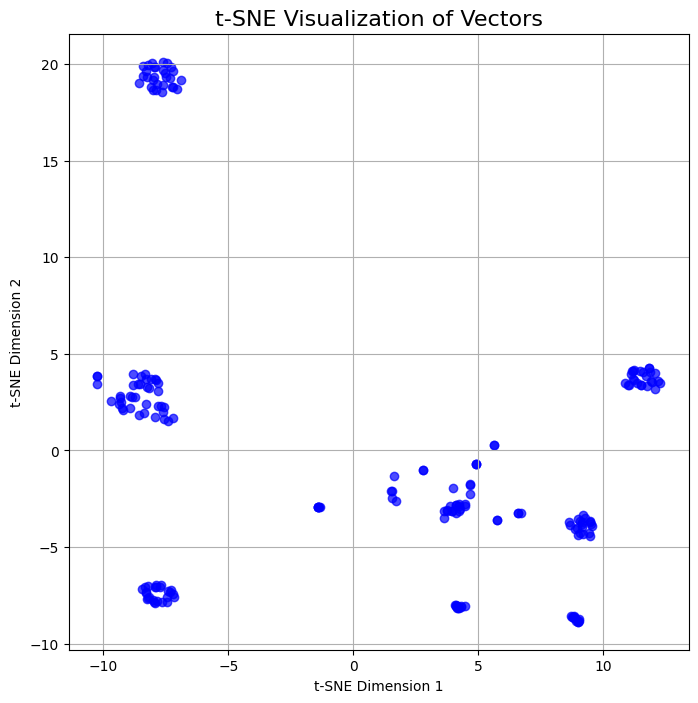

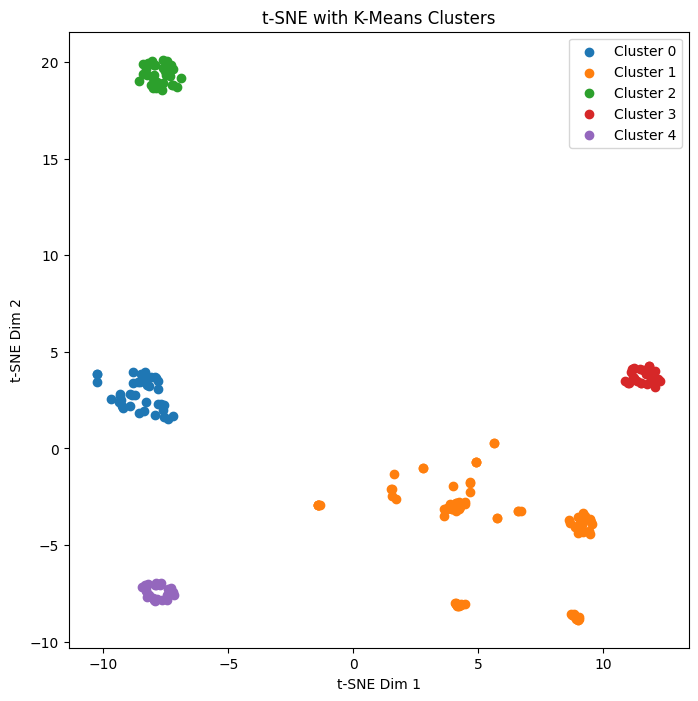

Cluster 1: (count: 91)
Ticks lasted: 928
Remaining time: 2747
Remaining rocks: 19
Victim harm: 280
Round num: 4

Cluster 3: (count: 25)
Ticks lasted: 1217
Remaining time: 2847
Remaining rocks: 13
Victim harm: 320
Round num: 5

Cluster 2: (count: 29)
Ticks lasted: 1259
Remaining time: 2525
Remaining rocks: 13
Victim harm: 327
Round num: 5

Cluster 0: (count: 39)
Ticks lasted: 683
Remaining time: 2254
Remaining rocks: 11
Victim harm: 294
Round num: 5

Cluster 4: (count: 25)
Ticks lasted: 761
Remaining time: 2407
Remaining rocks: 8
Victim harm: 384
Round num: 5

Closest point to centroid of Cluster 0: situation_90
Closest point to centroid of Cluster 1: situation_79
Closest point to centroid of Cluster 2: situation_114
Closest point to centroid of Cluster 3: situation_161
Closest point to centroid of Cluster 4: situation_122


In [ ]:
node_features = []
for data_sample in tqdm(dataset):
    with torch.no_grad():
        prediction = model(
            data_sample.node_features,
            data_sample.edge_index,
            data_sample.edge_type,
            data_sample.is_small_dim,
        )
    node_features.append(model.node_features_2.mean(dim=0).clone())

node_features = np.array(node_features)

# Apply t-SNE to reduce dimensions to 2D for visualization
tsne = TSNE(
    n_components=2,
    perplexity=30,  # Good balance for most datasets
    n_iter=2000,  # Enough for convergence
    learning_rate=200,  # Default, balanced value
    metric="euclidean",  # Use cosine for high-dimensional data
    init="pca",  # Stable initialization
    random_state=42,  # Reproducible results
)

vectors_2d = tsne.fit_transform(node_features)

# Plot the 2D visualization
plt.figure(figsize=(8, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c="blue", alpha=0.7)
plt.title("t-SNE Visualization of Vectors", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume `tsne_results` is the 2D output of t-SNE (shape: [num_points, 2])
# Number of clusters to form
num_clusters = 5

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors_2d)

# Visualize the clusters
plt.figure(figsize=(8, 8))
for cluster in range(num_clusters):
    plt.scatter(
        vectors_2d[cluster_labels == cluster, 0],
        vectors_2d[cluster_labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.legend()
plt.title("t-SNE with K-Means Clusters")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

from collections import Counter

cluster_dict = dict(Counter(cluster_labels))

ticks_lasted = []
remaining_time = []
remaining_rocks = []
victim_harm = []
round_num = []

for vertex in situation_vertices:
    cp_vertex = humemai.g.V(vertex).inE("has_situation").outV().next()
    properties = humemai.get_properties(cp_vertex)
    ticks_lasted.append(properties["ticks_lasted"])
    remaining_time.append(properties["remaining_time"])
    remaining_rocks.append(properties["remaining_rocks"])
    victim_harm.append(properties["victim_harm"])
    round_num.append(properties["round_num"])

ticks_lasted = np.array(ticks_lasted)
remaining_time = np.array(remaining_time)
remaining_rocks = np.array(remaining_rocks)
victim_harm = np.array(victim_harm)
round_num = np.array(round_num)

for label, val in cluster_dict.items():
    print(f"Cluster {label}: (count: {val})")
    print(f"Ticks lasted: {int(ticks_lasted[cluster_labels == label].mean())}")
    print(f"Remaining time: {int(remaining_time[cluster_labels == label].mean())}")
    print(f"Remaining rocks: {int(remaining_rocks[cluster_labels == label].mean())}")
    print(f"Victim harm: {int(victim_harm[cluster_labels == label].mean())}")
    print(f"Round num: {int(round_num[cluster_labels == label].mean())}")
    print()

import numpy as np

# Get the cluster centroids from K-Means
centroids = kmeans.cluster_centers_

# Find the closest data point to each centroid
closest_points = []

for cluster_id in range(num_clusters):
    # Get the indices of points in the current cluster
    cluster_points = vectors_2d[cluster_labels == cluster_id]
    original_indices = np.where(cluster_labels == cluster_id)[0]

    # Compute the distances to the centroid
    distances = np.linalg.norm(cluster_points - centroids[cluster_id], axis=1)

    # Find the index of the closest point
    closest_point_idx = original_indices[np.argmin(distances)]
    closest_points.append(closest_point_idx)


# Output the closest data points for each cluster
for cluster_id, point_idx in enumerate(closest_points):
    print(
        f"Closest point to centroid of Cluster {cluster_id}: {situation_vertices[point_idx].label}"
    )

### `g.V().hasLabel("situation_90", "situation_79", "situation_114", "situation_161", "situation_122")`

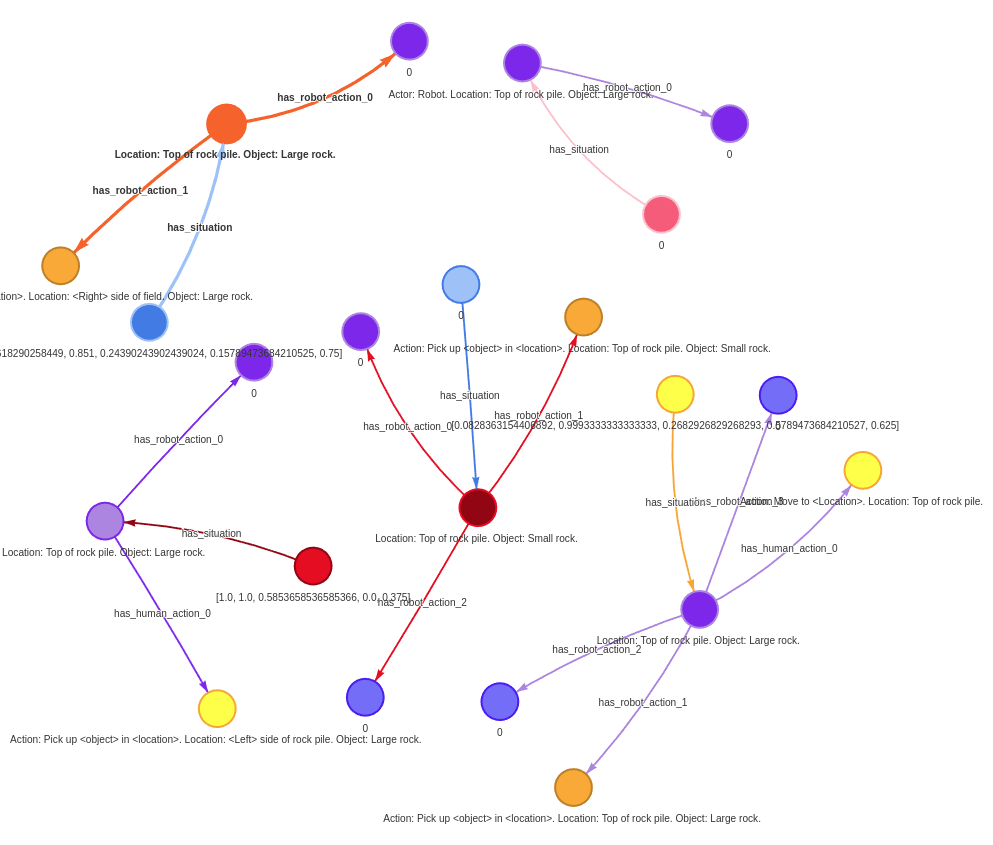
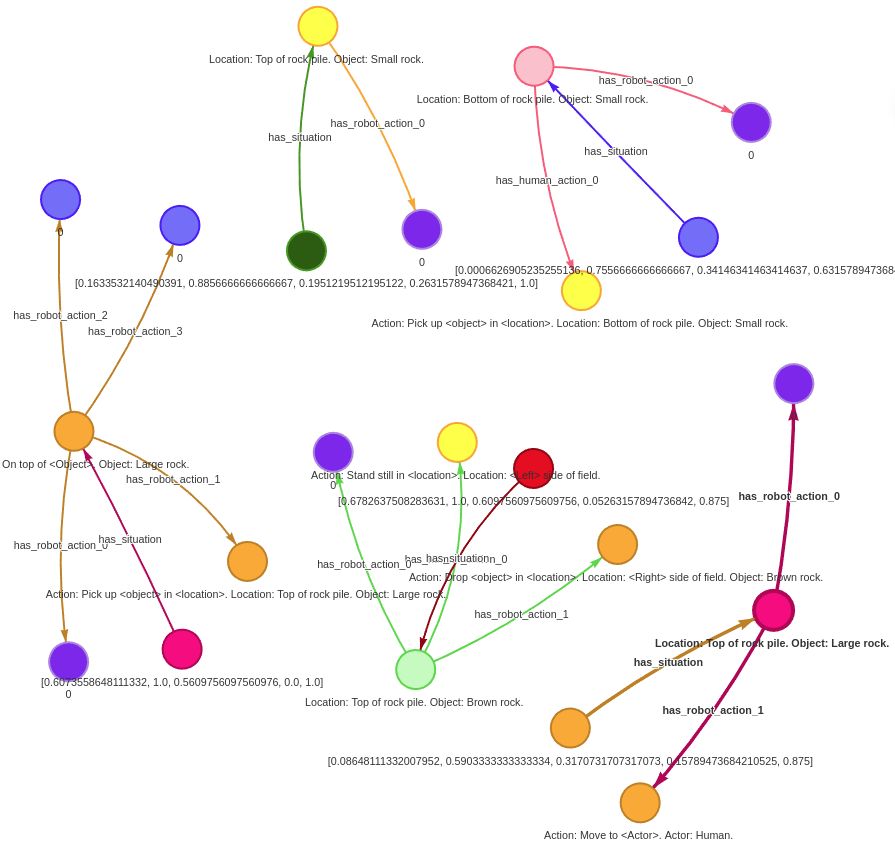

In [45]:
vertices, edges = humemai.get_within_hops([humemai.g.V().hasLabel("situation_90").next()], 1)
for vertex in vertices:
    try:
        print(vertex.label, humemai.get_properties(vertex)["sentence_representation"])
    except:
        print(vertex.label, humemai.get_properties(vertex))

situation_90 Location: Top of rock pile. Object: Large rock. 
cp_90 {'num_recalled': 0, 'cp_num': 90, 'ticks_lasted': 183, 'remaining_time': 2553, 'participant_num': 4087, 'remaining_rocks': 10, 'vector_representation': '[0.06063618290258449, 0.851, 0.24390243902439024, 0.15789473684210525, 0.75]', 'cp_name': 'Move', 'victim_harm': 300, 'round_num': 6, 'event_time': '2024-07-03T10:43:10'}
robot_action_1 Action: Drop <object> in <location>. Location: <Right> side of field. Object: Large rock. 
robot_action_0 Action: Pick up <object> in <location>. Location: Top of rock pile. Object: Large rock. 
